In [2]:
import sys
sys.path.append('/home/koreyr/scripts')
from block import *
from traj_calc import *
from free_energy import *

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from xvg_file import subplot_snsheat, subplot_imshow

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")

In [4]:
ref = '/home/koreyr/work/FUS/aFUS/protein.ff.gro'
pdb = md.load(ref)
outdir = './Overall_analysis/'

In [56]:
traj_directories = {'Apo':'/home/koreyr/work/FUS/aFUS/', 'HD1':'/home/koreyr/work/FUS/hdFUS/', \
                       'HD2':'/home/koreyr/work/FUS/hdFUS_2x/', 'HD3':'/home/koreyr/work/FUS/hdFUS_3x/'}
analysis_directories = {'Apo':'/home/koreyr/work/FUS/16HD_FUS/aFUS/Analysis/', \
                        'HD1':'/home/koreyr/work/FUS/16HD_FUS/hdFUS/Analysis/', \
                       'HD2':'/home/koreyr/work/FUS/16HD_FUS/hdFUS_2x/Analysis/',\
                        'HD3':'/home/koreyr/work/FUS/16HD_FUS/hdFUS_3x/Analysis/'}

In [6]:
def ab_arrays(trj):
    # Compute Phi and Psi
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(psi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    
    Phi_all = phis
    Psi_all = psis
    alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
    alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
    alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)
    
    return {'Alpha Helix' : alphabeta_alpharight, 'Beta Sheet' : alphabeta_betasheet, 'ppII' : alphabeta_ppII}

In [7]:
def get_rgca(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    # put the CA entries equal to 1.0
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
        # calculate CA radius of gyration
    return md.compute_rg(trj, masses=np.array(mass_CA))

In [8]:
nres = []
top = pdb.topology
system_info = {'apo':{}, 'HD1':{}, 'HD2':{}, 'HD3':{}, }
for res in top.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in pdb.topology.residues])
resname = (' %s' % [residue.name for residue in pdb.topology.residues])
resindex = (' %s' % [residue.index for residue in pdb.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))
for system in traj_directories.keys():
    trj_temp = md.load(traj_directories[system]+'prod.xtc',top=ref)
    system_info[system]["startframe"] = 0
    system_info[system]["nframes"] = trj_temp.n_frames
    system_info[system]["lastframe"] = trj_temp.n_frames
    system_info[system]["tlength"] = trj_temp.timestep * trj_temp.n_frames / 1e6

In [43]:
sequence = ['GLY1', '', '', '', '', 'ASP6', '', '', '', '', 'ALA11', '', '', '', '', 'GLY16', '', '', '', '', \
            'GLN21', '', '','','', 'TYR26','', '', '', '', 'SER31', '', '', '', '', 'GLN36', '', '', '', '', \
            'GLY41', '', '', 'GLN44']

In [10]:
#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms:    %d\n" % pdb.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("========= System specific info ==========")
print(len(traj_directories.keys()))
print(f"System:           {'     '.join(traj_directories.keys())}")
nfstring = '   '.join([str(system_info[i]["nframes"]) for i in traj_directories.keys()])
print(f"Number of frames: {nfstring}\n")
nfstring = '       '.join([str(system_info[i]["startframe"]) for i in traj_directories.keys()])
print(f"Starting frame:   {nfstring}\n")
nfstring = '   '.join([str(system_info[i]["lastframe"]) for i in traj_directories.keys()])
print(f"Last frame:       {nfstring}\n")
nfstring = '  '.join([str(system_info[i]["tlength"])[:3]+' us' for i in traj_directories.keys()])
print(f"Simulation Length:{nfstring}\n")
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

#residues = 58
#residue_offset = 390
residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)

** SYSTEM INFO **

Number of atoms:    624

Number of residues: 44

Number of protein residues: 42

========= System specific info ==========
4
System:           apo     HD1     HD2     HD3
Number of frames: 46823   40193   18325   15558

Starting frame:   0       0       0       0

Last frame:       46823   40193   18325   15558

Simulation Length:3.7 us  3.2 us  1.4 us  1.2 us

sequence:  [NGLY1, MET2, ALA3, SER4, ASN5, ASP6, TYR7, THR8, GLN9, GLN10, ALA11, THR12, GLN13, SER14, TYR15, GLY16, ALA17, TYR18, PRO19, THR20, GLN21, PRO22, GLY23, GLN24, GLY25, TYR26, SER27, GLN28, GLN29, SER30, SER31, GLN32, PRO33, TYR34, GLY35, GLN36, GLN37, SER38, TYR39, SER40, GLY41, TYR42, SER43, CGLN44]

residue names:  ['NGLY', 'MET', 'ALA', 'SER', 'ASN', 'ASP', 'TYR', 'THR', 'GLN', 'GLN', 'ALA', 'THR', 'GLN', 'SER', 'TYR', 'GLY', 'ALA', 'TYR', 'PRO', 'THR', 'GLN', 'PRO', 'GLY', 'GLN', 'GLY', 'TYR', 'SER', 'GLN', 'GLN', 'SER', 'SER', 'GLN', 'PRO', 'TYR', 'GLY', 'GLN', 'GLN', 'SER', 'TYR', 'SER', 'GLY'

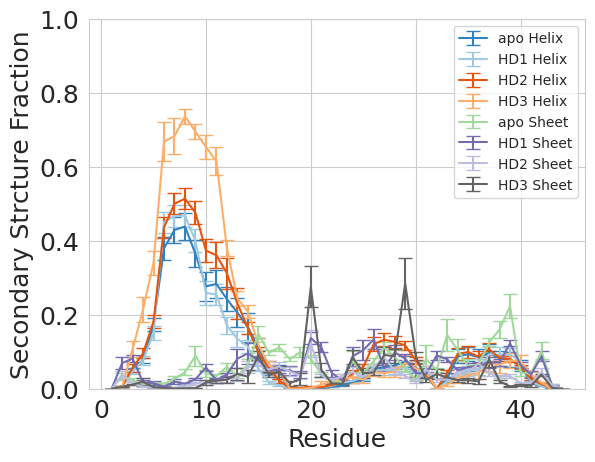

In [11]:
H1 = top.select("resid 0 to 43")
count=0
for system in traj_directories.keys():
    H = np.loadtxt(analysis_directories[system]+'Hprop.err.dat')
    plt.errorbar(H[:, 0], H[:, 1], yerr=H[:, 2], capsize=5, label=system+' Helix', c=plt.cm.tab20c(count*2), linestyle='-')
    count+=1
    
count=0
for system in traj_directories.keys():
    E = np.loadtxt(analysis_directories[system]+'Eprop.err.dat')
    plt.errorbar(E[:, 0], E[:, 1], yerr=E[:, 2], capsize=5, label=system+' Sheet', c=plt.cm.tab20c(count*2+10), linestyle='-')
    count+=1
    
plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


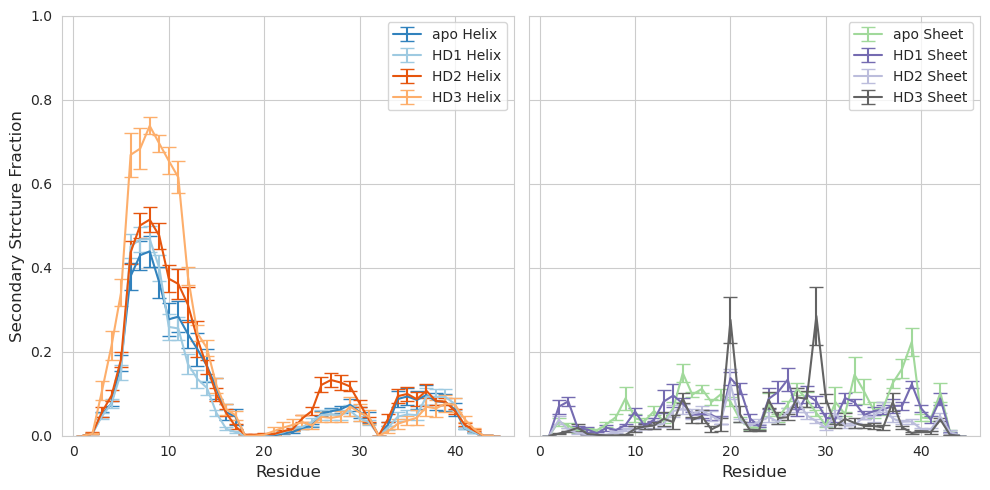

In [12]:
H1 = top.select("resid 0 to 43")
count=0
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
for system in traj_directories.keys():
    H = np.loadtxt(analysis_directories[system]+'Hprop.err.dat')
    ax[0].errorbar(H[:, 0], H[:, 1], yerr=H[:, 2], capsize=5, label=system+' Helix', c=plt.cm.tab20c(count*2), linestyle='-')
    count+=1

count=0
for system in traj_directories.keys():
    E = np.loadtxt(analysis_directories[system]+'Eprop.err.dat')
    ax[1].errorbar(E[:, 0], E[:, 1], yerr=E[:, 2], capsize=5, label=system+' Sheet', c=plt.cm.tab20c(count*2+10), linestyle='-')
    count+=1

ax[0].set_ylim(0, 1.0)
ax[1].set_ylim(0, 1.0)
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
ax[0].set_xlabel('Residue', size=12)
ax[1].set_xlabel('Residue', size=12)
ax[0].set_ylabel('Secondary Strcture Fraction', size=12)
#plt.tick_params(labelsize=18)
plt.tight_layout()

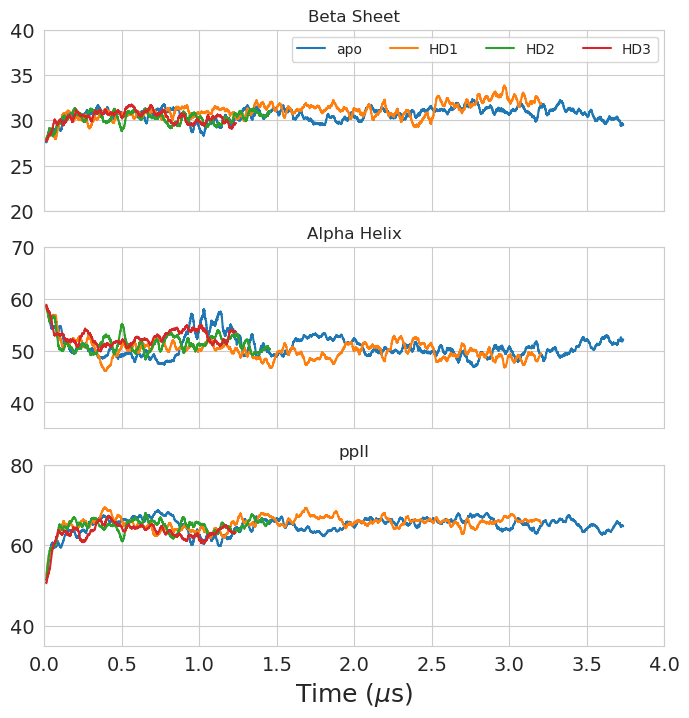

In [13]:
fig, ax = plt.subplots(3, figsize=((8, 8)), sharex=True)
N = 300
for system in traj_directories.keys():
    trj_temp = md.load(traj_directories[system]+'prod.xtc', top=ref)
    
    Ttotal,dt = np.array([trj_temp.n_frames*trj_temp.timestep, trj_temp.timestep])/1000000
    time = np.arange(0,Ttotal,dt)
    time_window = np.convolve(time, np.ones(N)/N, mode='valid')
    abpii = ab_arrays(trj_temp)

    ax[0].set_ylim(20,40)
    ax[0].set_title('Beta Sheet')
    ax[0].plot(time_window, np.convolve(abpii['Beta Sheet'], \
                                       np.ones(N)/N, mode='valid'), label=system)
    ax[0].set_xlim(0,4)

    ax[1].set_ylim(35,70)
    ax[1].set_title('Alpha Helix')
    ax[1].plot(time_window, np.convolve(abpii['Alpha Helix'], \
                                      np.ones(N)/N, mode='valid'))
    ax[1].set_xlim(0,4)

    ax[2].set_ylim(35,80)
    ax[2].set_title('ppII')
    ax[2].plot(time_window, np.convolve(abpii['ppII'], \
                                       np.ones(N)/N, mode='valid'))
    
    ax[2].set_xlim(0,4)
    ax[0].tick_params(labelsize=14)
    ax[1].tick_params(labelsize=14)
    ax[2].tick_params(labelsize=14)

ax[0].legend(loc='upper right', ncols=4)
#ax[1].legend(loc='upper right', ncols=4)
#ax[2].legend(loc='upper right', ncols=4)

plt.xlabel(r'Time ($\mu$s)', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')

/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)
/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)
/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


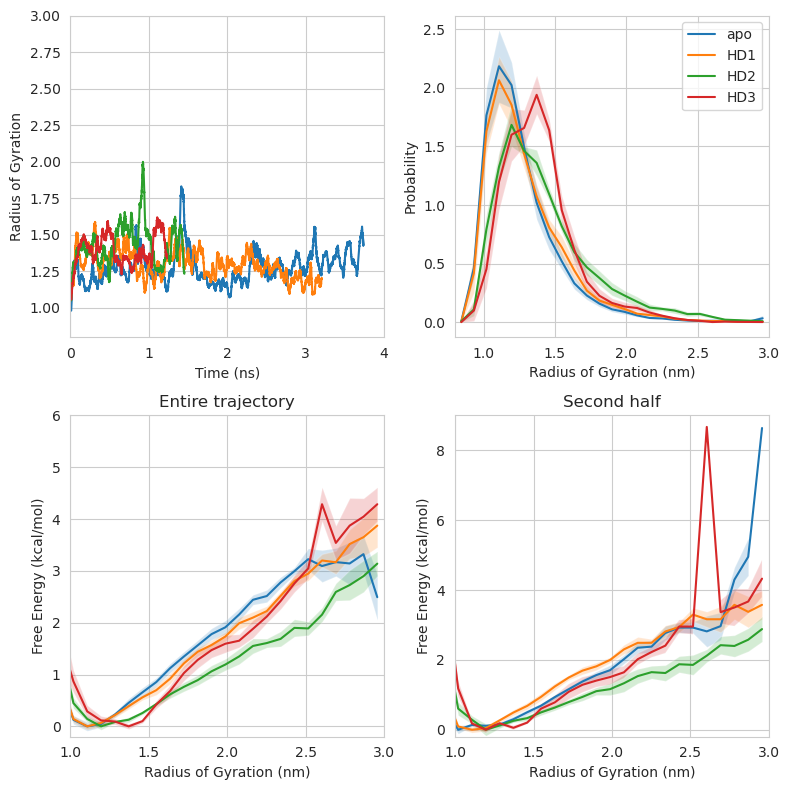

In [42]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=((8, 8)), sharex=False)
axs = ax.flatten()
N = 300
for system in traj_directories.keys():
    trj_temp = md.load(traj_directories[system]+'prod.xtc', top=ref)
    Ttotal,dt = np.array([trj_temp.n_frames*trj_temp.timestep, trj_temp.timestep])/1000000
    time = np.arange(0,Ttotal,dt)
    time_window = np.convolve(time, np.ones(N)/N, mode='valid')
    rg_CA = get_rgca(trj_temp)
    axs[0].plot(time_window,np.convolve(rg_CA, np.ones(N)/N, mode='valid'), label=system)
    
    Rg_unbound, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

    axs[1].plot(edges, Rg_unbound, label=system)#, label='unbound')
    axs[1].fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, alpha=0.2)
    
    dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
    sns.lineplot(x=bin_centers, y=dG, ax=axs[2])
    axs[2].fill_between(bin_centers, dG-ferr, dG+ferr, alpha=0.2)
    
    half = int(trj_temp.n_frames/2)
    dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA[half:], 300, 0.8, 3.0, 25, 5)
    sns.lineplot(x=bin_centers, y=dG, ax=axs[3])
    axs[3].fill_between(bin_centers, dG-ferr, dG+ferr, alpha=0.2)
    
axs[3].set_ylim(-0.2, 9)
axs[3].set_xlim(1.0, 3.0)
axs[3].set_xlabel('Radius of Gyration (nm)')
axs[3].set_ylabel('Free Energy (kcal/mol)')
axs[3].set_title('Second half')

axs[2].set_ylim(-0.2, 6)
axs[2].set_xlim(1.0, 3.0)
axs[2].set_xlabel('Radius of Gyration (nm)')
axs[2].set_ylabel('Free Energy (kcal/mol)')
axs[2].set_title('Entire trajectory')

axs[1].set_xbound(lower=0.8, upper=3.0)
axs[1].set_xlabel('Radius of Gyration (nm)')
axs[1].set_ylabel('Probability')
#axs[1].set_xticks(fontsize=20)
#axs[1].set_yticks(fontsize=20)
#axs[1].set_xticks(size='15')
#axs[1].set_yticks(size='15')
axs[1].legend(loc='upper right')

axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Radius of Gyration')
axs[0].set_ylim(0.8, 2.25)
#axs[0].tick_params(labelsize=18)
axs[0].set_ylim(0.8,3)
axs[0].set_xlim(0,4)
plt.tight_layout()
plt.savefig(outdir+'rg.pdf')

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_22109/1613359320.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if system is not 'Apo':


([<matplotlib.axis.XTick at 0x7f019be78e50>,
 [Text(0, 0, 'GLY1'),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, 'ASP6'),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, 'ALA11'),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, 'GLY16'),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, 'GLN21'),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, 'TYR26'),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, 'SER31'),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, 'GLN36'),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, 'GLY41'),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, 'GLN44')])

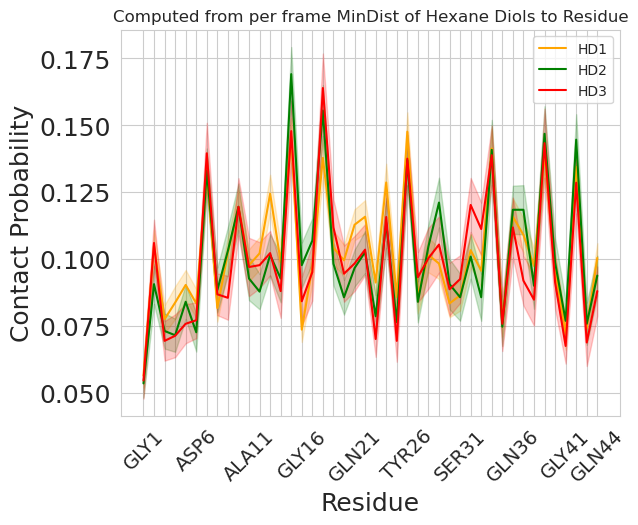

In [84]:
color_it = {'Apo':'blue', 'HD1': 'orange', 'HD2':'green','HD3':'red'}
for system in traj_directories.keys():
    if system is not 'Apo':
        Contact = np.loadtxt(analysis_directories[system]+'contact.be.pyblock.dat')
        sns.lineplot(x=Contact[:, 0], y=Contact[:, 1], label=system, c=color_it[system])
        plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],\
                         Contact[:, 1]-Contact[:, 2], color=color_it[system], alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.title('Computed from per frame MinDist of Hexane Diols to Residue')
plt.xticks(range(0, 44), sequence, rotation=45, size=14)

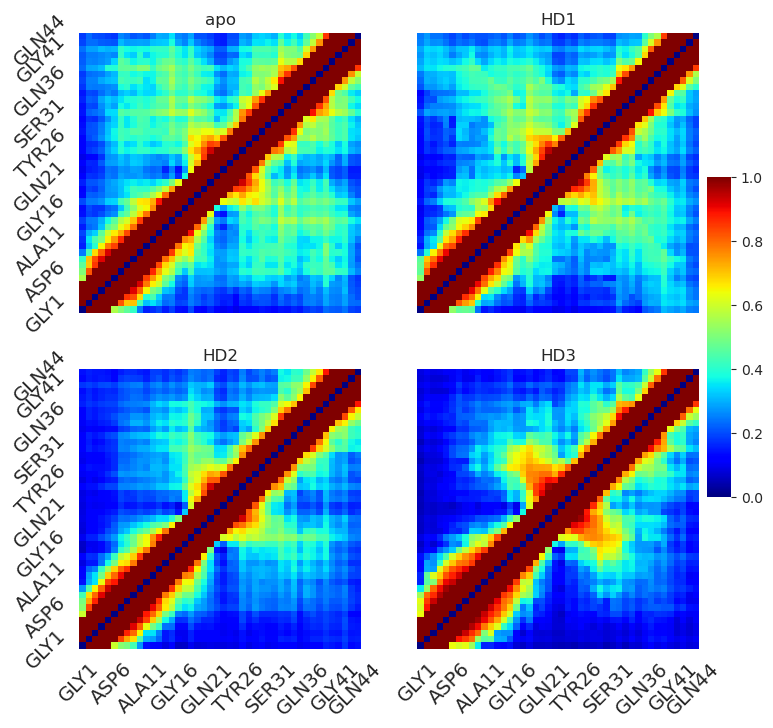

In [54]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=((8, 8)), sharex=True, sharey=True)
axs = ax.flatten()
cbar_ax = fig.add_axes([.91, .3, .03, .4])
N = 300
systems = list(traj_directories.keys())
for i in range(len(systems)):
    contact_map = np.loadtxt(analysis_directories[systems[i]]+'contactmap.dat')
    cb = i==1
    subplot_snsheat(contact_map, ax=axs[i], cbar=cb, cbar_ax=cbar_ax)
    axs[i].set_title(systems[i])
    axs[i].grid(which='both', alpha=0.5)
    axs[i].set_xticks(range(0, 44), sequence, rotation=45, size=14)
    axs[i].set_yticks(range(0, 44), sequence, rotation=45, size=14)
    axs[i].invert_yaxis()
    

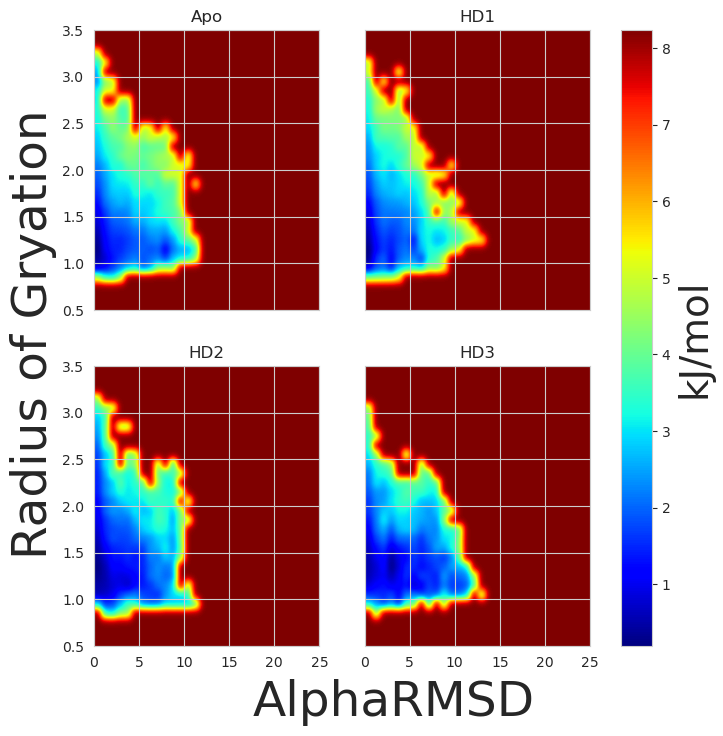

In [85]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=((8, 8)), sharex=True, sharey=True)
axs = ax.flatten()
systems = list(traj_directories.keys())
for i in range(len(systems)):
    rg_CA = np.loadtxt(analysis_directories[systems[i]]+'rg.dat')
    Sa_total = np.loadtxt(analysis_directories[systems[i]]+'Sa_total.dat')
    a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.5, 3.5], [0, 25.0]], normed=True, weights=None)
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a

    im = axs[i].imshow(a, interpolation='gaussian', \
                    extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
    axs[i].set_title(systems[i])
fig.supylabel("Radius of Gryation", size=35)
fig.supxlabel("AlphaRMSD", size=35)
cb = fig.colorbar(im, ax=axs.ravel().tolist())
cb.set_label('kJ/mol',rotation=90, fontsize=28)
